In [1]:
import cv2
from matplotlib import pyplot as plt
from adaptive_filt import *
from sample_viewer import display

# Image processing

The goal of this project was to have some kind of real-time ASL interpreter that could be used with relative ease by the user. There are some examples out there that classify ASL static symbols but all of them usually restrict the user to a specific region of interest on the image with a blank background. Most of them also work only on the creators hands, meaning the dataset that was used to train their classifier was not diverse enough or at least no image processing techniques were used to normalize the samples pre-classification. So to summarize, the goals are:

  1. Ease of use
  2. Real-time
  3. Works on most hands

### Easy of use
The ease of use was achieved by `kinect-one` and `openni2`. Waving at the camera and having your hand immediately tracked makes it a lot more natural to the user. Since not everybody (or robot) owns a OpenNI-compatible 3D camera, the next addition to this package is the implementation of a hand tracker with `rgb` only cameras like a webcam with the use of Local Binary Pattern or Haar Cascades. 

### Real-time
The real time aspect really depends on the platform on which you are running this package (suicide for a Raspberry Pi but will work just fine on a i5 - 2.4 GHz laptop). Since ROS provides immediate use of concurrent programming with its nodal structure, all that had to be done was splitting the image gathering and image classification processes into two separate nodes that communicate with each other.

### Versatile
The final goal was to have the package work with all or at least most hands. This is a basic problem of classification. The two classifiers that were chosen are the Convolutional Neural Network (CNN) and the Support Vector Machine (SVM). There are two approaches to using these classifiers:
1. Train them with a very broad and diverse dataset
2. Normalize the samples gathered during runtime to have them resemble a specific dataset that was used for training
The first method works just fine the CNN. Tensorflow provides an architecture called Inception V3 that can classify up to 1000 classes. And we're talking about distinguishing flowers, cars, bridges, cats and dogs of different shapes and sizes in very noisy environments. The SVM on the other hand will have a hard time doing that mainly because the features will need to be a specific size (independant of the image size). Therefore, the approach that was chosen was the second one for both classifiers. The datasets are made of right hands (because ASL static symbols are right handed) of four people. A sample will usually look like this:

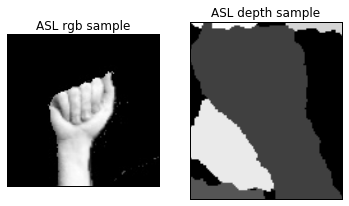

In [2]:
img = cv2.imread('../pictures/1.jpg', 0)
plt.subplot(1,2,1), plt.imshow(img, cmap='gray');
plt.title('ASL rgb sample'), plt.xticks([]), plt.yticks([]);

img = cv2.imread('../pictures/depth.png', 0)
plt.subplot(1,2,2), plt.imshow(img, cmap='gray');
plt.title('ASL depth sample'), plt.xticks([]), plt.yticks([]);

Once NiTE has detected a hand, it returns the coordinates of the centroid of the pixels representing the hand. This means that for a open-palm shaped hand, the centroid is going to be further from the wrist. Therefore, the wrist is not as visible. This behaviour will affect all samples with the same manner meaning there is no adjustment to be done for the dataset (ie having hands in different parts of the region of interest).

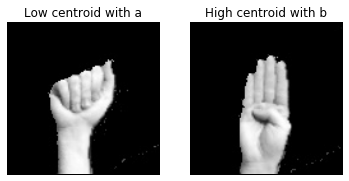

In [3]:
img = cv2.imread('../pictures/1.jpg', 0)
plt.subplot(1,2,1), plt.imshow(img, cmap='gray');
plt.title('Low centroid with a'), plt.xticks([]), plt.yticks([]);

img = cv2.imread('../pictures/2.jpg', 0);
plt.subplot(1,2,2), plt.imshow(img, cmap='gray');
plt.title('High centroid with b'), plt.xticks([]), plt.yticks([]);

Here are the steps to obtain an image like that:

  1. Get the coordinates of the centroid of the hand.
  2. Crop a ROI of a specified size (120 x 120 in this case) in the depth map and registered rgb map.
  3. Compute the distance of the hand by average a $M_8$ neighborhood (to avoid a dead pixel).
  4. Use the depth map to threshold the image around that distance.
  
For laplacian of depth samples, the laplacian has to be computed before step 4 to prevent getting higher values at the edges. The goal is to have images independant of the placement of the hand. If the laplacian is done after step 4, if the hand is placed at a distance $d$, the derivative at the edges between the hand and the background that was thresholded to 0 will be $\pm d$. This means that samples will depend on the distance.

### SVM
The SVM was trained with rgb images only. The chosen features are a histogram of sobel gradient magnitudes and orientations (HOG) and non-zero values counts in each column and rows of the image (120x120). HOG features are useful because they provide edge detection. It provides finer detail for harder symbols like `m` and `n` letters. There is a limitaiton to HOG: it does not provide good results with different lighting or different skin tones. In other words, derivatives will generate different values for a darker skin or a hand taken in dark light (or vice-versa for brighter images). Since the second approach of training was chosen, there was a need of normalizing the images to a desired reference. By measuring the average intensity of the pixels belonging to the hand and applying a gamma correction, most images can be normalized to a specific average of 160.

$\gamma_c = \sqrt[60]{3}^{-\Delta \mu}$

Details are found in `adaptive_filter.py`.

Non-zero values are useful to detect the general shape of the hand. Those features alone bring up about two thirds of the classifier's accuracy.

Original average : 162
Darker average : 88
Corrected average : 168


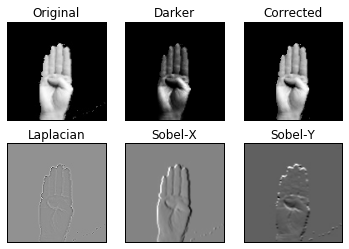

In [4]:
display(img, plt.figure());

Note: Pixel intensities in gradient images are shifted up. Gray is black, black is negative and white is positive.

### CNN
The CNN dataset is made out of rgb and depth images convolved with the isotropic derivative kernel: Laplacian. This way, edges are detected through x and y in a single image. 

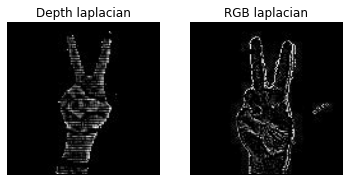

In [10]:
laplacian = cv2.imread('../pictures/4.jpg', 0) * 4
plt.subplot(1,2,1), plt.imshow(laplacian, cmap='gray');
plt.title('Depth laplacian'), plt.xticks([]), plt.yticks([]);

laplacian_rgb = cv2.imread('../pictures/3.jpg', 0) * 4
plt.subplot(1,2,2), plt.imshow(laplacian_rgb, cmap='gray');
plt.title('RGB laplacian'), plt.xticks([]), plt.yticks([]);

To create variation for the CNN dataset, one can alter the script `run.sh`. Random intensity and size multipliers can alter the image before training. This step is not very useful since the images are normalized anyway and the ROI is always 120x120. 

A first attempt was to use laplacian depth images (to check variations of depth independently of hand depth) to train the CNN. Altough it worked for the most part, it had a hard time classifying similarly shaped letters like `m` and `n` or even `s` and `t`. Laplacian of rgb images offered better results because finer detail is easily picked by the camera.

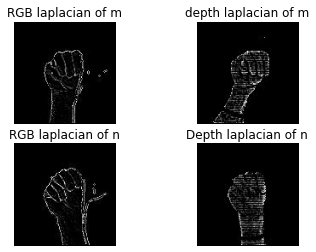

In [6]:
plt.subplot(2,2,1);
img = cv2.imread('../pictures/m_rgb.jpg') * 2
plt.imshow(img, cmap='gray');
plt.title('RGB laplacian of m'), plt.xticks([]), plt.yticks([]);

plt.subplot(2,2,2);
img = cv2.imread('../pictures/m_depth.jpg') * 4
plt.imshow(img, cmap='gray');
plt.title('depth laplacian of m'), plt.xticks([]), plt.yticks([]);

plt.subplot(2,2,3);
img = cv2.imread('../pictures/n_rgb.jpg') * 2;
plt.imshow(img, cmap='gray');
plt.title('RGB laplacian of n'), plt.xticks([]), plt.yticks([]);

plt.subplot(2,2,4)
img = cv2.imread('../pictures/n_depth.jpg') * 4;
plt.imshow(img, cmap='gray');
plt.title('Depth laplacian of n'), plt.xticks([]), plt.yticks([]);

This is mainly because the Kinect One uses time of flight to compute the depth map. It is not ideal for small variations of depth, like fingers. The Kinect 360 on the other hand uses light projection at different frequencies and infers depth from it. The result is much more precise. Here is a side by side comparison of the laplacians of the Kinect One and the Kinect 360. On the Kinect 360 image, the same depth levels are clearly displayed with plateau-like areas whereas on the Kinect One, it is barely perceptible.

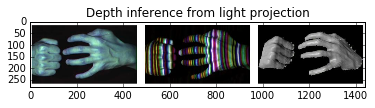

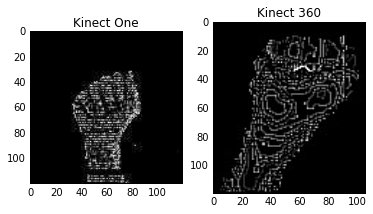

In [4]:
plt.figure();
img = cv2.imread('../pictures/light_projection.png', cv2.COLOR_BGR2RGB);
plt.imshow(img), plt.title('Depth inference from light projection');

plt.figure(), plt.subplot(1,2,1);
img = cv2.imread('../pictures/kinectOne_depth.jpg') * 4;
plt.imshow(img), plt.title('Kinect One');

plt.subplot(1,2,2);
img = cv2.imread('../pictures/kinect360_depth.jpg') * 2;
plt.imshow(img), plt.title('Kinect 360');

### Chosen classifier
The CNN, although slightly more accurate, demends a lot more computing power than the SVM. The SVM is over 5x faster at classifying the way everything is currently implemented. Chosing to alter the architecture will mean a drop in accuracy which would make it pointless. Therefore, the chosen classifier is the SVM. One thing to keep in mind is that the way this package works is not by classifying a single image but rather a sequence of images. After a certain amount of classifications of the same letter, the prediction of the symbol is shown. In this case, accuracy meant only with single images. One can always adjust their hand position to get a stable reading and have 100% accuracy all the time.